CLASS IMBALACE HANDLING TECHNIQUES
1.	Easy Ensemble + SMOTE
2.	Cost-Sensitive Learning (Class Weighting)
3.	Anomaly Detection Models
    3.1	Isolation Forest
    3.2	One-Class SVM
    3.3	Autoencoders
4.	Graph-Based Oversampling (GraphSMOTE, GNNs)
5.	Time-Based Validation + Drift Handling


Understanding the Imbalance Problem in Blockchain Fraud Detection:
In blockchain fraud detection, we face a fundamental challenge: fraudulent transactions (what we're trying to detect) are significantly outnumbered by legitimate transactions. This imbalance creates several problems:
1. Models tend to favor the majority class (legitimate transactions) because it improves overall accuracy
2. The minority class (fraudulent transactions) doesn't provide enough patterns for the model to learn from
3. Traditional algorithms often struggle to identify the rare fraudulent cases
4. Performance metrics can be misleading if not carefully selected

This severe class imbalance means that even a model that classifies everything as legitimate could achieve high accuracy (e.g., 99% if fraud is only 1% of transactions), while being completely useless for fraud detection. To address this challenge, we need specialized techniques like SMOTE and Easy Ensemble.

1. Easy Ensemble + SMOTE

What is SMOTE and How Does It Work?

SMOTE (Synthetic Minority Over-sampling Technique) is an approach that creates synthetic examples for the minority class rather than simply duplicating existing examples. This provides new information to the model instead of just repeating the same patterns.

SMOTE works through the following steps:
1. It selects a random example from the minority class (a fraudulent transaction in our case)
2. Finds its k nearest neighbors (other similar fraudulent transactions)
3. Selects one of these neighbors randomly
4. Creates a synthetic example by drawing a line between the original example and the selected neighbor, then placing the new example somewhere along this line

In simpler terms, SMOTE creates new fraudulent transaction examples that have characteristics similar to real fraud but aren't exact duplicates. This helps the model learn more robust patterns of what constitutes fraud.

The mathematical approach behind SMOTE involves:
1. Finding similar fraudulent transactions in feature space
2. Creating new examples that maintain the essential characteristics of fraud while introducing some variation
3. Generating these examples as a "convex combination" of existing examples (essentially, a weighted average of feature values)

This approach is particularly effective because it creates plausible new examples rather than arbitrary ones, helping the model build more robust decision boundaries around minority class examples.




Understanding Easy Ensemble
Easy Ensemble is a technique specifically designed for imbalanced datasets. It creates multiple balanced training sets from the original imbalanced data, trains a separate model on each balanced set, and combines their predictions.

The process works as follows:
1. It creates multiple balanced training sets by:
2. Keeping all examples from the minority class (fraudulent transactions)
3. Randomly undersampling the majority class (legitimate transactions) to match the number of minority examples
4. Repeating this process multiple times to create different balanced subsets
5. For each balanced subset, it trains a model (typically an AdaBoost classifier)
6. It combines the predictions from all models to make the final decision

Easy Ensemble is essentially a "bag of balanced boosted learners" - it creates multiple balanced samples and uses boosting techniques on each sample.

The key advantage is that while each individual model only sees a portion of the legitimate transactions, the ensemble as a whole considers all of them. This means we don't lose information from the majority class while still maintaining balance in training.




Combining SMOTE and Easy Ensemble for Blockchain Fraud Detection:
1. Preparation: First, preprocess your blockchain transaction data (normalizing features, encoding categorical variables, etc.)
2. Apply SMOTE: Use SMOTE to generate synthetic examples of fraudulent transactions, increasing their representation in the dataset
3. Implement Easy Ensemble: Apply Easy Ensemble on the SMOTE-enhanced dataset to create multiple balanced training sets and train an ensemble of models
4. Evaluation: Evaluate the model using appropriate metrics for imbalanced data (precision, recall, F1-score, area under the ROC curve)

This combination addresses both the lack of minority examples (using SMOTE) and the imbalanced nature of the dataset (using Easy Ensemble).

In [ ]:
# Step 1: Data Collection and Preprocessing


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load your blockchain transaction data
# This would include features like transaction amount, time patterns, 
# network metrics, account behaviors, etc.
data = pd.read_csv('blockchain_transactions.csv')

# Separate features and target
X = data.drop('is_fraud', axis=1)
y = data['is_fraud']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
#Step 2: Apply SMOTE to Balance the Training Data

from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)

# Apply SMOTE to the training data
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Check the class distribution after SMOTE
print("Class distribution after SMOTE:", np.bincount(y_train_smote))


#Here, SMOTE creates synthetic examples of fraudulent transactions based on existing ones. 
# The sampling_strategy='auto' parameter tells SMOTE to generate enough synthetic examples to make the classes balanced


In [ ]:
#Step 3: Implement Easy Ensemble Classifier

from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the Easy Ensemble Classifier
# n_estimators: Number of AdaBoost learners in the ensemble
# random_state: For reproducibility
easy_ensemble = EasyEnsembleClassifier(
    n_estimators=10,
    random_state=42,
    sampling_strategy='auto',
    replacement=False,
    n_jobs=-1  # Use all available CPU cores
)

# Train the model on the SMOTE-enhanced data
# You can also apply Easy Ensemble directly without SMOTE
# Let's try both approaches
model_with_smote = easy_ensemble.fit(X_train_smote, y_train_smote)
model_without_smote = easy_ensemble.fit(X_train_scaled, y_train)

#The EasyEnsembleClassifier creates multiple balanced training sets by randomly undersampling the majority class.
# Each balanced set is used to train an AdaBoost classifier (the default estimator)


In [ ]:
#Step 4: Make Predictions and Evaluate

# Make predictions
y_pred_with_smote = model_with_smote.predict(X_test_scaled)
y_pred_without_smote = model_without_smote.predict(X_test_scaled)

# Get probability predictions (useful for adjusting the threshold)
y_pred_proba_with_smote = model_with_smote.predict_proba(X_test_scaled)[:, 1]

# Evaluate the models
print("Performance with SMOTE + Easy Ensemble:")
print(classification_report(y_test, y_pred_with_smote))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_with_smote))

print("\nPerformance with Easy Ensemble only:")
print(classification_report(y_test, y_pred_without_smote))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_without_smote))


In [ ]:
#Step 5: Fine-tuning and Optimization

# Tuning SMOTE parameters
smote_tuned = SMOTE(
    sampling_strategy=0.5,  # Adjust ratio of minority to majority (0.5 = 1:2 ratio)
    k_neighbors=5,          # Number of nearest neighbors to use
    random_state=42
)

# Tuning Easy Ensemble parameters
easy_ensemble_tuned = EasyEnsembleClassifier(
    n_estimators=50,               # More estimators often improve performance
    estimator=None,                # Default is AdaBoostClassifier
    sampling_strategy='auto',      # Automatically determine the sampling strategy
    replacement=False,             # Sample without replacement
    n_jobs=-1,                     # Use all available cores
    random_state=42,
    verbose=1                      # Show progress during training
)


Advanced Implementation Details

Customizing the Base Estimator

By default, EasyEnsembleClassifier uses AdaBoostClassifier as the base estimator, but you can substitute it with any classifier:

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# Create a custom AdaBoost with specified parameters
base_estimator = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=3),
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)

# Use this custom estimator in the Easy Ensemble
easy_ensemble_custom = EasyEnsembleClassifier(
    estimator=base_estimator,
    n_estimators=10,
    random_state=42
)


Dealing with Feature Importance

Understanding which features contribute most to fraud detection is crucial. Easy Ensemble allows you to extract this information:

In [ ]:
# If using the default AdaBoost inside Easy Ensemble
importances = []
for estimator in easy_ensemble.estimators_:
    # Each estimator is an AdaBoost classifier
    for base_estimator in estimator.estimators_:
        # Extract feature importance from each base estimator (if it has this attribute)
        if hasattr(base_estimator, 'feature_importances_'):
            importances.append(base_estimator.feature_importances_)

# Average importances across all base estimators
if importances:
    avg_importances = np.mean(importances, axis=0)
    feature_importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': avg_importances
    }).sort_values('Importance', ascending=False)
    print(feature_importance_df)


Adjusting the Decision Threshold

For fraud detection, we often want to adjust the classification threshold to favor recall (detecting more frauds) at the cost of precision:

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get predicted probabilities
y_pred_proba = model_with_smote.predict_proba(X_test_scaled)[:, 1]

# Calculate precision and recall for different thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)

# Plot precision-recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')

# Choose a threshold that gives desired recall
desired_recall = 0.95  # We want to catch 95% of frauds
idx = np.argmin(np.abs(recall - desired_recall))
selected_threshold = thresholds[idx]
print(f"Threshold for {desired_recall:.2f} recall: {selected_threshold:.3f}")

# Apply the new threshold
y_pred_custom_threshold = (y_pred_proba >= selected_threshold).astype(int)

# Evaluate with the new threshold
print("\nPerformance with custom threshold:")
print(classification_report(y_test, y_pred_custom_threshold))


Real-time Processing Considerations

In [ ]:
# This code would be part of your production fraud detection system
import joblib

# Load the pre-trained models
scaler = joblib.load('scaler_model.pkl')
fraud_model = joblib.load('fraud_detection_model.pkl')

def predict_fraud(transaction_features):
    """
    Predict if a new blockchain transaction is fraudulent.
    
    Args:
        transaction_features: Features of the transaction to check
        
    Returns:
        fraud_probability: Probability of fraud
        is_fraud: Boolean prediction
    """
    # Preprocess features
    features_scaled = scaler.transform([transaction_features])
    
    # Get fraud probability
    fraud_probability = fraud_model.predict_proba(features_scaled)[0, 1]
    
    # Apply threshold (potentially adjusted based on business needs)
    threshold = 0.7  # Higher threshold means fewer false positives
    is_fraud = fraud_probability >= threshold
    
    return fraud_probability, is_fraud


IMPLEMENTING ON THE DATASET THAT I HAVE


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.58      0.73    100755
           1       0.73      1.00      0.84       676
           2       1.00      0.99      0.99     16617
           3       0.18      0.92      0.30     10240

    accuracy                           0.66    128288
   macro avg       0.72      0.87      0.72    128288
weighted avg       0.92      0.66      0.73    128288

Macro F1-score: 0.7178
Weighted F1-score: 0.7310


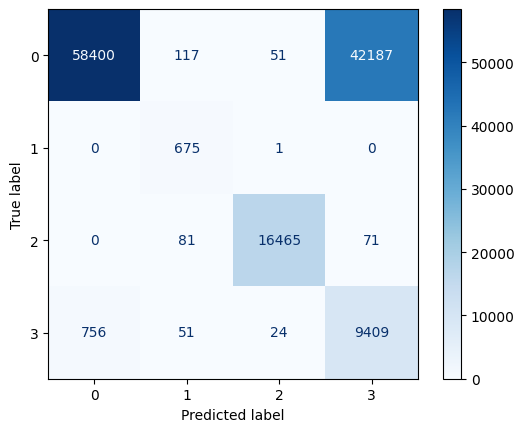

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.metrics import classification_report, f1_score, ConfusionMatrixDisplay

# 1. Load the dataset
df = pd.read_csv("dataset.csv")

# 2. Split features and target
X = df.drop(columns=["Unnamed: 0", "label"])
y = df["label"]

# 3. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, stratify=y, random_state=42
)

# 5. Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X_train, y_train)

# 6. Train Easy Ensemble Classifier
ee = EasyEnsembleClassifier(random_state=42, n_estimators=10)
ee.fit(X_res, y_res)

# 7. Predict on test set
y_pred = ee.predict(X_test)

# 8. Evaluation
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Optional: F1 scores
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"Macro F1-score: {f1_macro:.4f}")
print(f"Weighted F1-score: {f1_weighted:.4f}")

# Optional: Confusion Matrix
ConfusionMatrixDisplay.from_estimator(ee, X_test, y_test, cmap="Blues")
